In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 1. Data Loading & Preprocessing

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

mask_train = (train_labels == 2) | (train_labels == 6)
mask_test  = (test_labels  == 2) | (test_labels  == 6)

X_train = train_images[mask_train].reshape(-1, 784).astype('float32') / 255.0
X_test  = test_images[mask_test].reshape(-1, 784).astype('float32')  / 255.0

y_train = np.where(train_labels[mask_train] == 2, -1, 1)
y_test  = np.where(test_labels[mask_test]   == 2, -1, 1)

# Subset training data for tractable KNN computation
X_train_sub = X_train[:1000]
y_train_sub = y_train[:1000]

print(f'Train subset: {X_train_sub.shape}, Full test: {X_test.shape}')

Train subset: (1000, 784), Full test: (1990, 784)


## 2. k-NN Implementation

In [3]:
def knn_predict(X_train, y_train, X_query, k):
    predictions = np.empty(len(X_query), dtype=int)
    for i, x in enumerate(X_query):
        dists   = np.sqrt(np.sum((X_train - x) ** 2, axis=1))
        k_idx   = np.argpartition(dists, k)[:k]
        predictions[i] = 1 if np.sum(y_train[k_idx]) > 0 else -1
    return predictions

def zero_one_loss(y_true, y_pred):
    return np.mean(y_true != y_pred)

## 3. Experiments: Sweep over k

In [4]:
k_values = [1, 3, 5, 7]
results  = {}

for k in k_values:
    train_pred = knn_predict(X_train_sub, y_train_sub, X_train_sub, k)
    test_pred  = knn_predict(X_train_sub, y_train_sub, X_test,      k)

    results[k] = {
        'train_error': zero_one_loss(y_train_sub, train_pred),
        'test_error':  zero_one_loss(y_test,       test_pred),
    }
    print(f'k={k}: Train Loss={results[k]["train_error"]:.4f} | Test Loss={results[k]["test_error"]:.4f}')

k=1: Train Loss=0.0000 | Test Loss=0.0075


k=3: Train Loss=0.0020 | Test Loss=0.0060


k=5: Train Loss=0.0060 | Test Loss=0.0070


k=7: Train Loss=0.0060 | Test Loss=0.0085


## 4. Visualization

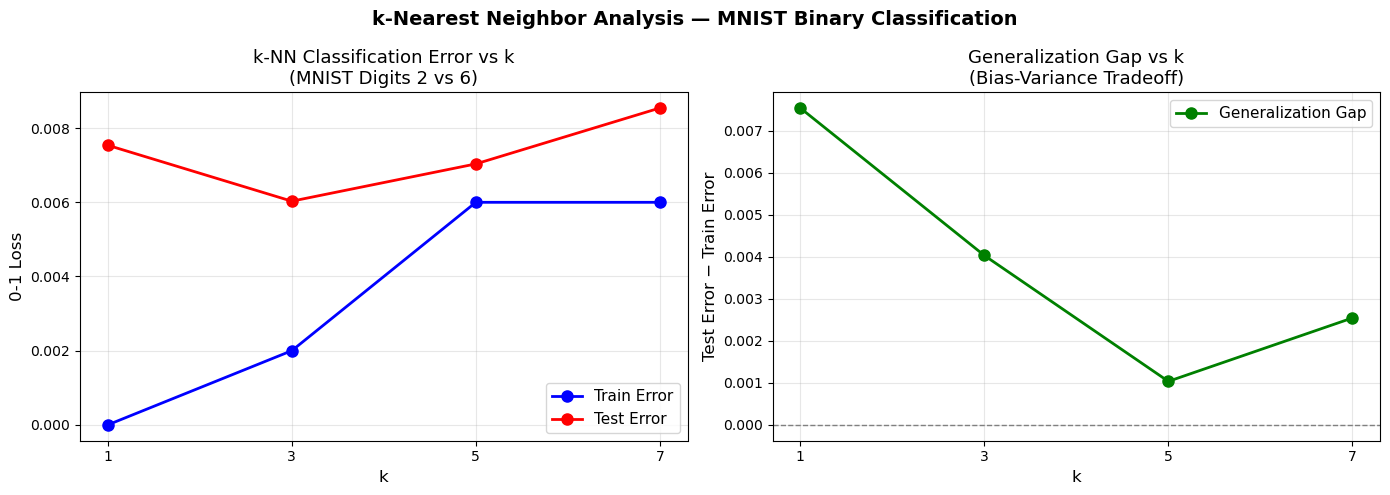

In [5]:
k_arr       = np.array(k_values)
train_errs  = np.array([results[k]['train_error'] for k in k_values])
test_errs   = np.array([results[k]['test_error']  for k in k_values])
gen_gap     = test_errs - train_errs

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_arr, train_errs, 'bo-', linewidth=2, markersize=8, label='Train Error')
axes[0].plot(k_arr, test_errs,  'ro-', linewidth=2, markersize=8, label='Test Error')
axes[0].set_xlabel('k', fontsize=12)
axes[0].set_ylabel('0-1 Loss', fontsize=12)
axes[0].set_title('k-NN Classification Error vs k\n(MNIST Digits 2 vs 6)', fontsize=13)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_arr)

axes[1].plot(k_arr, gen_gap, 'go-', linewidth=2, markersize=8, label='Generalization Gap')
axes[1].axhline(y=0, color='gray', linestyle='--', linewidth=1)
axes[1].set_xlabel('k', fontsize=12)
axes[1].set_ylabel('Test Error − Train Error', fontsize=12)
axes[1].set_title('Generalization Gap vs k\n(Bias-Variance Tradeoff)', fontsize=13)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_arr)

plt.suptitle('k-Nearest Neighbor Analysis — MNIST Binary Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/knn_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Results Summary

In [6]:
best_k = min(results, key=lambda k: results[k]['test_error'])

print('{:>4}  {:>16}  {:>14}  {:>10}'.format('k','Train 0-1 Loss','Test 0-1 Loss','Gen. Gap'))
print('-' * 50)
for k in k_values:
    r   = results[k]
    gap = r['test_error'] - r['train_error']
    marker = ' <- best' if k == best_k else ''
    print('{:>4}  {:>16.4f}  {:>14.4f}  {:>10.4f}{}'.format(k, r['train_error'], r['test_error'], gap, marker))

print(f'\nOptimal k = {best_k} (Test Loss = {results[best_k]["test_error"]:.4f})')

   k    Train 0-1 Loss   Test 0-1 Loss    Gen. Gap
--------------------------------------------------
   1            0.0000          0.0075      0.0075
   3            0.0020          0.0060      0.0040 <- best
   5            0.0060          0.0070      0.0010
   7            0.0060          0.0085      0.0025

Optimal k = 3 (Test Loss = 0.0060)
